<!--HEADER-->
*Notas de aula de Modelagem Matemática - 2020/2 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2020p2/notas_de_aula/13.00-Propagacao_incertezas.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/julia-env-for-binder?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252Fmodelagem_matematica%26branch%3Dmodmat2020p2%26urlpath%3Dtree%252Fmodelagem_matematica%252Fnotas_de_aula/13.00-Propagacao_incertezas.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2020p2/notas_de_aula/slides/13.00-Propagacao_incertezas.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 12. Mínimos quadrados, maximização da verossimilhança e quantificação de incertezas em regressões lineares](12.00-Minimos_quadrados_verossimilhanca.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) 

---


# Propagação de incertezas


In [1]:
using Plots
using Distributions
using Random
using LsqFit
using Optim
using Statistics

## Introdução

* Dado um modelo $y=f(\boldsymbol\beta, \mathbf{x})$, onde $\beta$ indica um vetor de parâmetros do modelo e $x$ um vetor de variáveis independentes, buscamos estimar as incertezas em $y$ em termos de incertezas em $\boldsymbol\beta$ e em $\mathbf{x}$.

* De maneira análoga, podemos buscar entender quão sensível a resposta $y$ é a  variações em $\boldsymbol\beta$ e em $\mathbf x$.

* No último caderno, vimos isso no caso de um modelo linear $y=\beta_0 + \beta_1 x$ e de incertezas na escolha dos parâmetros $\beta_0$ e $\beta_1$.

* Vamos, agora, explorar mais um pouco essa questão.

* Podemos, naturalmente, considerar um modelo vetorial, $\mathbf{y} = \mathbf{f}(\boldsymbol\beta, \mathbf{x})$. Mas, em muitos casos, essa análise, pode ser reduzida ao caso escalar, coordenada a coordenada. Para simplificar, vamos considerar apenas o caso escalar.

## Incertezas

* Nessa quantificação de incertezas, ou de análise de sensibilidade, tanto os parâmetros $\boldsymbol\beta$ como as variáveis independentes $\mathbf x$ são consideradas variáveis aleatórias.

* Vamos denotar as incertezas nessas quantidades por $\delta\boldsymbol\beta$ e $\delta\mathbf x$.

* Ou, em coordenadas específicas, $\delta\beta_j$ e $\delta x_i$.

## Propagação de incertezas em modelos lineares

* Vamos começar com um modelo linear afim
$$ y = \beta_0 + \beta_1 x_1 + \ldots + \beta_m x_m = \boldsymbol\beta \mathbf{x},
$$
onde $\mathbf{x} = (1, x_1, x_m)$.

* Este é um modelo em $m$-dimensões, com $m+1$ parâmetros. Apenas uma ligeira extensão do caso visto recentemente.

* Nesse caso, a propagação em relação aos parâmetros é como antes:
$$ \delta y = \delta\beta_0 + \delta\beta_1 x_1 + \ldots + \delta\beta_m x_m = (\delta \boldsymbol\beta) \mathbf{x}.
$$

* Escrevendo $x_0 = 1$ para simplificar, a variância de $y$ é como antes:
$$ \operatorname{Var}(y) = E((\delta y)^2) = E\left(((\delta \boldsymbol\beta) \mathbf{x})^2\right) = E\left(\left(\sum_{j=0}^m (\delta\beta_j) x_j\right)^2\right) =  E\left(\sum_{i,j=0}^m (\delta\beta_i)(\delta\beta_j)x_ix_j\right) \\ = \sum_{i,j=0}^m E((\delta\beta_i)(\delta\beta_j))x_ix_j =  \mathbf{x}^T \operatorname{Cov}(\delta\boldsymbol\beta)\mathbf{x}.
$$

## Propagação local de incertezas via derivação

* Para variações pequenas, em modelos não-lineares, podemos linearizar o modelo.

* No caso $y = f(\boldsymbol\beta, \mathbf{x})$,
$$\delta y = f(\hat{\boldsymbol\beta} + \delta\boldsymbol\beta,\mathbf{x}) - f(\hat{\boldsymbol\beta}) \approx \nabla_{\boldsymbol\beta} f(\hat{\boldsymbol\beta}, \mathbf{x}) (\delta\boldsymbol\beta).
$$

* Com a linearização,
$$ \operatorname{Var}(y) = \nabla_{\boldsymbol\beta} f(\hat{\boldsymbol\beta}, \mathbf{x})^T\operatorname{Cov}(\delta\boldsymbol\beta) \nabla_{\boldsymbol\beta} f(\hat{\boldsymbol\beta}, \mathbf{x})
$$


## Propagação global via método de Monte-Carlo

* Há uma série de métodos globais, como o de [Morris *one-at-a-time* (OTA)](https://en.wikipedia.org/wiki/Morris_method), [Sobol/Variância](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) e [Quasi-Monte Carlo](https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method).

* Aqui, no entanto, vamos considerar apenas o [método de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) usual.

* Neste método, geramos aleatoriamente uma amostra de parâmetros, segundo uma determinada distribuição, aplicamos no modelo e calculamos as estatísticas do resultado.

## Exemplo de reação enzimática

* Neste exemplo, vamos usar aproximação local por derivação para estimar o erro nos parâmetros.

* E vamos usar propagação global via método de Monte-Carlo para estimar o erro no modelo a partir dos erros locais nos parâmetros.

* O exemplo é o mesmo exemplo de reação enzimática feito no caderno sobre otimização não-linear.

### Definindo os parâmetros da reação original

In [2]:
function model(t, β)
    ν_m = β[1]
    K_M = β[2]
    v = (ν_m .* t) ./ (K_M .+ t)
    return v
end

ν_m = 0.3
K_M = 0.5
β = [ν_m K_M]
nothing

### Colhendo amostra e visualizando os dados

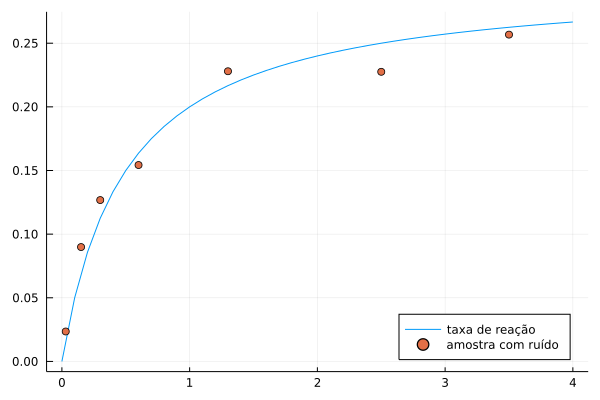

In [3]:
data_t = [0.03, 0.15, 0.3, 0.6, 1.3, 2.5, 3.5]
data_v = model(data_t, β) .+ 0.05*(rand(MersenneTwister(321), length(data_t)) .- 0.5)
t = 0:0.1:4
plot(t, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")

### Ajustando os parâmetros via `LsqFit`

In [4]:
β₀ = [0.5, 0.5]
fit = curve_fit(model, data_t, data_v, β₀)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.27385430554237405, 0.3573547044880839], [-0.0023055639474684336, -0.008885236342096231, -0.0017870073920807084, 0.01733948083515205, -0.013158516357111155, 0.012074220204586372, -0.008253562394493624], [0.0774483945908297 -0.05475492120163171; 0.2956511463714009 -0.15958330270278243; … ; 0.8749351265570832 -0.08385544542674134; 0.9073575722523881 -0.06441818211562214], true, Float64[])

### Estatísticas do ajuste

* Abaixo, obtemos

    * os parâmetros ajustados;

    * o erro padrão;

    * a margem de 95% de erro;

    * o intervalo de 95% de confiança;

    * a matriz variância-covariância.

In [5]:
β_fit = fit.param

2-element Vector{Float64}:
 0.27385430554237405
 0.3573547044880839

In [6]:
σ = stderror(fit)

2-element Vector{Float64}:
 0.012327062980326473
 0.05942357175835884

In [7]:
margin_of_error = margin_error(fit, 0.05)

2-element Vector{Float64}:
 0.031687724183972074
 0.1527531541706683

In [8]:
confidence_inter = confidence_interval(fit, 0.05)

2-element Vector{Tuple{Float64, Float64}}:
 (0.24216658135840197, 0.30554202972634614)
 (0.2046015503174156, 0.5101078586587522)

In [9]:
covar = estimate_covar(fit)

2×2 Matrix{Float64}:
 0.000151956  0.000589671
 0.000589671  0.00353116

### Observações

* O erro padrão é a raiz quadrada dos elementos da diagonal da matriz de variância-covariância.

* A matriz de variância-covariância é obtida via aproximação local, a partir da matriz jacobiana e do erro quadrático médio.

In [10]:
sqrt.([covar[1,1],covar[2,2]])

2-element Vector{Float64}:
 0.012327062980326473
 0.05942357175835884

In [11]:
jac = fit.jacobian

7×2 Matrix{Float64}:
 0.0774484  -0.0547549
 0.295651   -0.159583
 0.456375   -0.190126
 0.626727   -0.179277
 0.784382   -0.129608
 0.874935   -0.0838554
 0.907358   -0.0644182

In [12]:
mse(fit) * inv(jac' * jac)

2×2 Matrix{Float64}:
 0.000151956  0.000589671
 0.000589671  0.00353116

### Amostragem dos parâmetros

* Pelo método de Monte Carlo, fazemos uma amostragem nos parâmetros e observamos as estatísticas do resultado do modelo com esses parâmetros.

* Como os parâmetros estão correlacionados, usamos uma normal bidimensional, com a matriz de variância-covariância fornecida pelo método de otimização.

* Observe a seguir a diferença entre fazer a amostragem levando em consideração ou não a correlação entre os parâmetros.

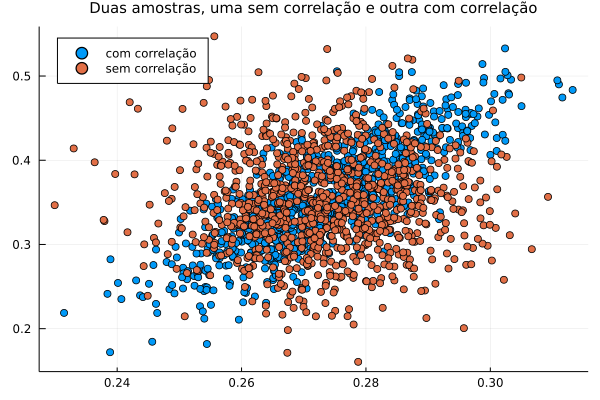

In [13]:
num_amostras = 1000
plot(title="Duas amostras, uma sem correlação e outra com correlação", titlefont=10)
scatter!((r -> (r[1,:], r[2,:]))(rand(MvNormal(β_fit,covar), num_amostras)), label="com correlação")
scatter!((rand(Normal(β_fit[1],σ[1]),num_amostras),
        rand(Normal(β_fit[2],σ[2]),num_amostras)), label="sem correlação",
        legend=:topleft)

### Resultado da propagação de erro via Método de Monte Carlo

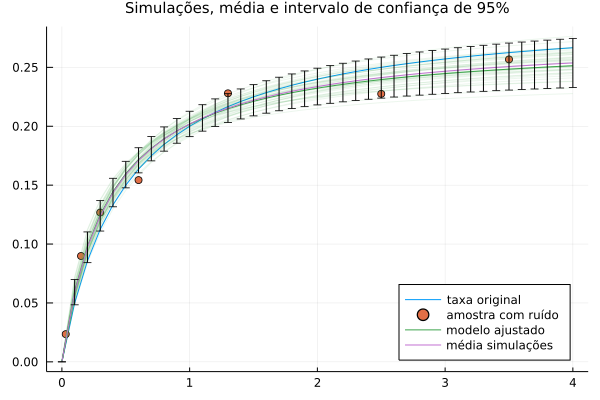

In [14]:
t = 0:0.1:4
num_amostras = 40
simulations = fill(0.0, length(t), num_amostras)
media = zero(t)
plot(t, t -> model(t, β), label="taxa original", legend=:bottomright,
    title="Simulações, média e intervalo de confiança de 95%", titlefont=10)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(t, t -> model(t, β_fit), label="modelo ajustado", legend=:bottomright)
rand
for (n,β̃) in enumerate(eachcol(rand(MersenneTwister(13000), MvNormal(β_fit,covar), num_amostras)))
    modelagem = model.(t,Ref(β̃))
    simulations[:,n] = model.(t,Ref(β̃))
    plot!(t, simulations[:,n], label=false, alpha=0.1 , legend=:bottomright, color=3)
end
plot!(t, mean(simulations, dims=2), yerror=2*sqrt.(var(simulations, dims=2)), color=4,
    label="média simulações")

## Exercícios

1. Refaça os exemplos do caderno sobre **Modelos redutíveis ao caso linear nos parâmetros e aplicações** como problemas de otimização não-linear e faça as estatísticas de cada um deles, como feito acima.

1. Compare os intervalo de confiança obtidos no exercício acima com os intervalos de confiança obtidos no caderno anterior, sobre **Mínimos quadrados, maximização da verossimilhança e quantificação de incertezas em regressões lineares**, feito transformando os problemas e regressões lineares.

<!--NAVIGATOR-->

---
[<- 12. Mínimos quadrados, maximização da verossimilhança e quantificação de incertezas em regressões lineares](12.00-Minimos_quadrados_verossimilhanca.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) 